## 必要なライブラリのインストール(必須)

FlaskとGemini API  
python-dotenvはAPIキーを安全に管理するために推奨

In [ ]:
# Google Driveのマウント（＝Google Drive内のデータへアクセスできるようにする）
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install Flask
!pip install google-generativeai
!pip install python-dotenv

## (1)-(6)は仮の実装でまだ使えない

## (1)環境設定とFlaskアプリケーションの初期化

.envファイルにGemini APIのキーを設定し、それを読み込む

In [ ]:
import os
import google.generativeai as genai
from flask import Flask, request, jsonify

# 環境変数からAPIキーを読み込む
from dotenv import load_dotenv
load_dotenv()

genai.configure(api_key=os.environ.get("GEMINI_API_KEY"))
# print(os.environ.get("GEMINI_API_KEY"))

app = Flask(__name__)

## (2)ルートと関数の定義
キャラクター情報を生成するためのエンドポイントを定義

In [ ]:
@app.route('/generate_character_info', methods=['POST'])
def generate_character_info():
    # ... ここに処理を記述 ...
    return jsonify({"description": description})

## (3)リクエストデータの取得と処理
フロントエンドから送られてくるJSONデータ（画像と名前）を取得し、Base64形式の画像データを適切に処理

In [ ]:
import base64

data = request.json
    image_data_base64 = data.get('image')
    character_name = data.get('name')
    user_features_text = data.get('features', '')

    # Base64文字列からMIMEタイプとエンコードされたデータを分離
    if 'data:' in image_data_base64:
        mime_type = image_data_base64.split(',')[0].split(':')[1].split(';')[0]
        encoded_data = image_data_base64.split(',')[1]
    else:
        # プレフィックスがない場合の処理
        mime_type = "image/png"  # または適切なもの
        encoded_data = image_data_base64

    # Base64データをデコード
    image_binary_data = base64.b64decode(encoded_data)

In [ ]:
# フロントエンドからのリクエストを模倣したデータ
mock_request_data = {
    "image": "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgA...",  # 実際のBase64データに置き換える
    "name": "ドリルうさぎ",
    "features": ""  # 任意の特徴テキスト
}

## (4)Gemini APIへの連携とプロンプトの作成

*   genai.GenerativeModelを使用してGeminiモデルをインスタンス化し、プロンプトとなるコンテンツリストを作成  
*   画像データとキャラクター名、必要に応じてユーザーが入力した特徴をプロンプトに含める



In [ ]:
try:
        model = genai.GenerativeModel('gemini-pro-vision')
        contents = [
            genai.types.Part(mime_type=mime_type, data=image_binary_data),
            f"このキャラクターの名前は「{character_name}」です。",
            "これらの情報をもとに、このキャラクターの魅力を伝える説明文を生成してください。"
        ]

        if user_features_text:
            contents.append(f"ユーザーが指定した特徴は「{user_features_text}」です。")

        response = model.generate_content(contents)
        description = response.text

## (5)レスポンスの返却とエラーハンドリング
生成された説明文をJSON形式でフロントエンドに返す

In [ ]:
return jsonify({"description": description})
    except Exception as e:
        return jsonify({"error": str(e)}), 500

## (6)アプリケーションの実行

In [ ]:
if __name__ == '__main__':
    app.run(debug=True)

# ＊とりあえず、フロントエンドなしで実行できるか確認したやつ

画像をBase64形式に変換



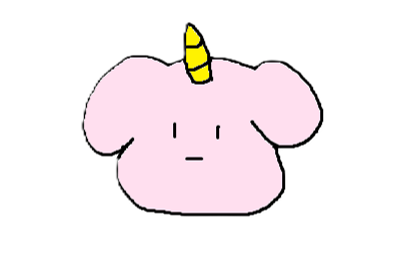

In [ ]:
import base64

def image_to_base64(filepath):
    """
    指定された画像ファイルをBase64文字列に変換する関数。
    """
    try:
        # バイナリモードで画像ファイルを読み込む
        with open(filepath, "rb") as image_file:
            # Base64にエンコード
            encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
            # データのプレフィックスを追加
            return f"data:image/png;base64,{encoded_string}"
    except FileNotFoundError:
        return "ファイルが見つかりません。"
    except Exception as e:
        return f"エラーが発生しました: {e}"

# 変換したい画像ファイルのパス
image_file_path = "/content/drive/MyDrive/oekaki/image/rabit.png"

# 関数を実行して結果を出力
base64_string = image_to_base64(image_file_path)
print(base64_string)

実行

In [ ]:
import os
import google.generativeai as genai
import base64
from dotenv import load_dotenv

# プログラムの実行ディレクトリをoekakiフォルダに変更
os.chdir('/content/drive/MyDrive/oekaki/backend')

# 環境変数からAPIキーを読み込む
# .envファイルがoekakiフォルダにあるため、load_dotenv()はこのままでOK
load_dotenv()
genai.configure(api_key=os.environ.get("GEMINI_API_KEY"))


def image_to_base64(filepath, mime_type):
    """
    指定された画像ファイルをBase64文字列に変換し、プレフィックスを付加する関数。
    """
    try:
        with open(filepath, "rb") as image_file:
            encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
            return f"data:{mime_type};base64,{encoded_string}"
    except FileNotFoundError:
        return None
    except Exception as e:
        print(f"エラーが発生しました: {e}")
        return None

def generate_character_info_standalone(image_base64_string, character_name, user_features_text=''):
    """
    Base64文字列の画像データを使ってキャラクターの説明文を生成する関数。
    """
    try:
        # 1. Base64文字列からMIMEタイプとエンコードされたデータを分離
        if 'data:' in image_base64_string:
            mime_type = image_base64_string.split(',')[0].split(':')[1].split(';')[0]
            encoded_data = image_base64_string.split(',')[1]
        else:
            mime_type = "image/png"
            encoded_data = image_base64_string

        # 2. Base64データをデコード
        image_binary_data = base64.b64decode(encoded_data)

        # 3. デコードしたバイナリデータを一時ファイルとして保存し、アップロード
        # プログラムの実行ディレクトリにtemp_image.pngが作成される
        with open("temp_image.png", "wb") as f:
            f.write(image_binary_data)

        model = genai.GenerativeModel('gemini-1.5-flash')
        uploaded_file = genai.upload_file("temp_image.png")

        # 4. Geminiモデルの呼び出しとプロンプトの作成
        contents = [
            uploaded_file,
            f"このキャラクターの名前は「{character_name}」です。",
            "名前と絵の特徴からオリジナルの説明文を自動生成してください。",
            "・説明文はユーモアやファンタジー要素も入れられると面白いです。",
            "・職業、見た目、能力、性格などを考えて、図鑑を作ってみてください。"
        ]
        if user_features_text:
            contents.append(f"ユーザーが指定した特徴は「{user_features_text}」です。")

        # 5. APIの実行とレスポンスの取得
        response = model.generate_content(contents)
        description = response.text

        # 6. 一時ファイルの削除
        os.remove("temp_image.png")

        return description

    except Exception as e:
        return f"エラーが発生しました: {str(e)}"

if __name__ == '__main__':
    # 画像ファイルへの相対パスを指定
    image_path = "image/rabit.png"
    mime_type_for_file = "image/png"

    # 画像ファイルをBase64文字列に変換
    base64_string = image_to_base64(image_path, mime_type_for_file)

    if base64_string:
        # 変換したデータを使ってキャラクターの説明文を生成
        generated_description = generate_character_info_standalone(
            image_base64_string=base64_string,
            character_name="ドリルうさぎ",
            user_features_text="ふわふわした体とドリル状の角を持つ"
        )
        print("--- 生成された説明文 ---")
        print(generated_description)
    else:
        print("画像ファイルの処理に失敗しました。")

--- 生成された説明文 ---
## ドリルうさぎ図鑑

**学名:** *Lepus foraminiferus unicornis*

**和名:** ドリルうさぎ

**分類:** ウサギ目　ドリルうさぎ科　ドリルうさぎ属

**生息地:** 夢想世界のふわふわ雲の上、もしくは飼い主の心の平和な空間

**特徴:**

ふわふわで綿菓子のような体を持つ、愛くるしいウサギ型生物。最大の特長は、頭部から生える黄金色のドリル状の角。一見可愛らしい容姿とは裏腹に、このドリルは想像をはるかに超えるパワーを秘めている。硬度と回転力は驚異的で、ダイヤモンドをも砕くと言われている。しかし、ドリルは普段は飾りとして使われ、ほとんどが毛並みに埋もれている。

**見た目:**  ピンク色の、まるで雲のようなふわふわボディ。短い手足と、つぶらな瞳が何とも言えずキュート。そして、その頭に輝く黄金のドリルが、上品なアクセントとなっている。全体的に柔らかく、触ると気持ち良さそうな感触だと思われる。

**能力:**

* **超高性能ドリル:**  上記の通り、ダイヤモンドをも砕くほどの驚異的なパワーを持つ。ただし、制御が難しく、使いこなせるのはドリルうさぎ本人と、選ばれた数名のみ。
* **ふわふわボディ:**  敵の攻撃を吸収し、無効化する効果がある。攻撃よりも防御に特化している能力と言える。
* **奇跡の癒やし:**  ふわふわの体から発せられる癒やしの力は、疲れた心を優しく包み込む。触れただけで、心身ともに安らぎを得ることができる。
* **雲の上を歩く:**  生まれた時から雲の上を自由に歩行できる。ただし、地上では少々足取りが危なっかしい。

**性格:**

一見おとなしく、マイペースな性格。しかし、いざという時にはドリルを駆使し、持ち前のパワーで敵を圧倒する。意外にも勇敢で、正義感も強い。少し天然なところがあり、ドリルを忘れて家具にぶつかってしまうことも。好奇心旺盛で、新しいものにはすぐに飛びつく。

**生態:**

単独行動を好み、普段は雲の上でゆったりと過ごしている。しかし、困っている人を見つけると、迷わずドリルを駆使して助けに行く。食事は主に夢と希望の結晶で、時々空想のニンジンを食べる。

**その他:**

ドリルうさぎは、非常に希少な存在であり、その存在を